In [1]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import scanpy as sc
from scipy import sparse
from scipy.special import softmax

import networkx as nx
import torch

ROOT = Path('../')
sys.path.append(str(ROOT))
import came
from came import pipeline, pp, pl

Using backend: pytorch


## 0 Load data (`scanpy.AnnData` object)

In [2]:
# example_data_dict = came.load_example_data()
# print(example_data_dict.keys())

# dsnames = ('Baron_human', 'Baron_mouse')
# dsn1, dsn2 = dsnames

# adatas = example_data_dict['adatas']
# dsnames = example_data_dict['dataset_names']
# df_varmap = example_data_dict['varmap']
# df_varmap_1v1 = example_data_dict['varmap_1v1']

# key_class1 = key_class2 = example_data_dict['key_class']

# # setting directory for results
# time_tag = came.make_nowtime_tag()
# resdir = ROOT /'_temp' / f'{dsnames}-{time_tag}'
# figdir = resdir / 'figs'
# came.check_dirs(figdir)

In [3]:
# ========= customize paths ==========

tiss, (sp1, sp2) = 'brain', ('human', 'mouse')
dsnames = ('Lake_2018', 'Tasic18')
dsn1, dsn2 = dsnames

dir_gmap = Path('E:/lxy_pro/004/resources/mart_exports/exported_gene_matches')
datadir = Path('E:/lxy_pro/004/datasets') / 'formal' / tiss

df_varmap_1v1 = pd.read_csv(dir_gmap / f'gene_matches_1v1_{sp1}2{sp2}.csv', )
df_varmap = pd.read_csv(dir_gmap / f'gene_matches_{sp1}2{sp2}.csv', )

# setting directory for results
time_tag = came.make_nowtime_tag()
resdir = ROOT /'_case_res' / f'{dsnames}-{time_tag}'
figdir = resdir / 'figs'
came.check_dirs(figdir)

# loading data
dsn1, dsn2 = dsnames
adata_raw1 = sc.read_h5ad(datadir / f'raw-{dsn1}.h5ad')
adata_raw2 = sc.read_h5ad(datadir / f'raw-{dsn2}.h5ad')
adatas = [adata_raw1, adata_raw2]

key_class1 = 'cell_ontology_class'
key_class2 = 'cell_ontology_class'

a new directory made:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs


In [4]:
# ====== subsampling and filtering genes (optional) =====
for _adt, _name in zip([adata_raw1, adata_raw2], dsnames):
    if _adt.shape[0] >= 2e4:
        print(f'Doing subsampling for {_name}')
        sc.pp.subsample(_adt, fraction=0.5)

sc.pp.filter_genes(adata_raw1, min_cells=3)
sc.pp.filter_genes(adata_raw2, min_cells=3)

Doing subsampling for Lake_2018
Doing subsampling for Tasic18


In [5]:
# Inspect classes
pd.concat([
    pd.value_counts(adata_raw1.obs[key_class1]),
    pd.value_counts(adata_raw2.obs[key_class2]),
], axis=1)

,cell_ontology_class,cell_ontology_class
Purkinje cell,491.0,NaN
astrocyte,1279.0,286.0
brain pericyte,107.0,16.0
cerebellar granule cell,1676.0,NaN
endothelial cell,105.0,94.0
excitatory neuron,7390.0,5545.0
inhibitory neuron,3400.0,4863.0
macrophage,NaN,62.0
microglial cell,376.0,NaN
oligodendrocyte,2151.0,83.0


## 1 Run default pipeline of CAME

Parameter setting:

In [6]:
# the numer of training epochs
n_epochs = 350

# the training batch size (when GPU memory is limited, recommanded is 8192 or more)
batch_size = None  

# the number of epochs to skip for checkpoint backup
n_pass = 100

# whether to use the single-cell network
use_scnets = True

# node genes. Using DEGs and HVGs by default
node_source = 'deg,hvg'

In [7]:
came_inputs, (adata1, adata2) = pipeline.preprocess_unaligned(
    adatas,
    key_class=key_class1,
    use_scnets=use_scnets,
)

outputs = pipeline.main_for_unaligned(
    **came_inputs,
    df_varmap=df_varmap,
    df_varmap_1v1=df_varmap_1v1,
    dataset_names=dsnames,
    key_class1=key_class1,
    key_class2=key_class2,
    do_normalize=True,
    n_epochs=n_epochs,
    resdir=resdir,
    n_pass=n_pass,
    batch_size=batch_size,
    plot_results=True,
)
dpair = outputs['dpair']
trainer = outputs['trainer']
h_dict = outputs['h_dict']
out_cell = outputs['out_cell']
predictor = outputs['predictor']

obs_ids1, obs_ids2 = dpair.obs_ids1, dpair.obs_ids2
obs = dpair.obs
classes = predictor.classes

[leiden] Time used:  2.3300 s
groups to be removed:
	 []
500 genes before taking unique
taking total of 429 unique differential expressed genes
groups to be removed:
	 []
1000 genes before taking unique
taking total of 661 unique differential expressed genes
already exists:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs
already exists:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)
[*] Setting dataset names:
	0-->Lake_2018
	1-->Tasic18
[*] Setting aligned features for observation nodes (self._features)
[*] Setting un-aligned features (`self._ov_adjs`) for making links connecting observation and variable nodes
[*] Setting adjacent matrix connecting variables from these 2 datasets (`self._vv_adj`)
Index(['cell_ontology_class', 'cell_ontology_id', 'cell_type1', 'dataset_name',
       'donor', 'organ', 'organism', 'platform', 'region', 'tSNE1', 'tSNE2',
       'major_class'],
      dtype='object')
Index(['title', 'source_name', 'organism', 'donor_id', 'donor_sex',
  

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


Epoch 0000 | Train Acc: 0.4188 | Test: 0.5015 (max=0.5015) | AMI=0.0000 | Time: 1.2090
Epoch 0005 | Train Acc: 0.6269 | Test: 0.5069 (max=0.5085) | AMI=0.0742 | Time: 0.8584
Epoch 0010 | Train Acc: 0.5617 | Test: 0.5090 (max=0.5090) | AMI=0.1499 | Time: 0.8250
Epoch 0015 | Train Acc: 0.7486 | Test: 0.5286 (max=0.5286) | AMI=0.1650 | Time: 0.8109
Epoch 0020 | Train Acc: 0.8104 | Test: 0.9409 (max=0.9409) | AMI=0.4847 | Time: 0.8065
Epoch 0025 | Train Acc: 0.8674 | Test: 0.9683 (max=0.9698) | AMI=0.4991 | Time: 0.8063
Epoch 0030 | Train Acc: 0.8971 | Test: 0.9669 (max=0.9698) | AMI=0.5060 | Time: 0.8046
Epoch 0035 | Train Acc: 0.9122 | Test: 0.9797 (max=0.9797) | AMI=0.5144 | Time: 0.8024
Epoch 0040 | Train Acc: 0.9189 | Test: 0.9803 (max=0.9803) | AMI=0.5143 | Time: 0.7999
Epoch 0045 | Train Acc: 0.9274 | Test: 0.9795 (max=0.9803) | AMI=0.5196 | Time: 0.7994
Epoch 0050 | Train Acc: 0.9289 | Test: 0.9791 (max=0.9803) | AMI=0.5196 | Time: 0.8022
Epoch 0055 | Train Acc: 0.9361 | Test: 0.97

C:\Users\Administrator\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\container.py:552: UserWarning: Setting attributes on ParameterDict is not supported.
  warnings.warn("Setting attributes on ParameterDict is not supported.")


astrocyte                          1565
inhibitory neuron                  8263
excitatory neuron                 12935
microglial cell                     376
oligodendrocyte                    2234
cerebellar granule cell            1676
oligodendrocyte precursor cell      669
endothelial cell                    199
Purkinje cell                       491
brain pericyte                      123
unknown                             169
dtype: int64
object saved into:
	 ..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\datapair_init.pickle
Re-order the rows
figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\contingency_matrix(acc97.8%).png
figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\contingency_matrix-train.png
figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\heatmap_probas.pdf


In [8]:
# load_other_ckpt = False
# if load_other_ckpt:
#     obs, df_probs, h_dict, predictor = pipeline.gather_came_results(
#             dpair,
#             trainer,
#             classes=ENV_VARs['classes'],
#             keys=(key_class1, key_class2),
#             keys_compare=(key_class1, key_class2),
#             resdir=resdir,
#             checkpoint='last',
#             batch_size=None,
#     )

### Plot cell-typing results

figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\contingency_mat.png


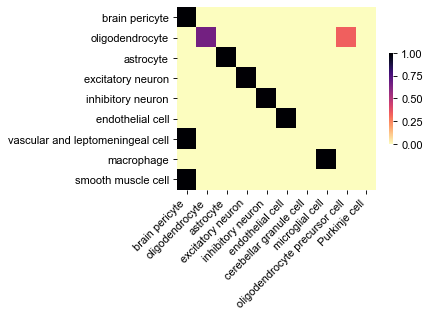

In [9]:
# contingency matrix for query dataset
y_true = obs['celltype'][obs_ids2].values
y_pred = obs['predicted'][obs_ids2].values
ax, contmat = pl.plot_contingency_mat(
    y_true, y_pred, norm_axis=1, 
    order_rows=False, order_cols=False,
)
pl._save_with_adjust(ax.figure, figdir / 'contingency_mat.png')
ax.figure

figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\heatmap_probas.pdf


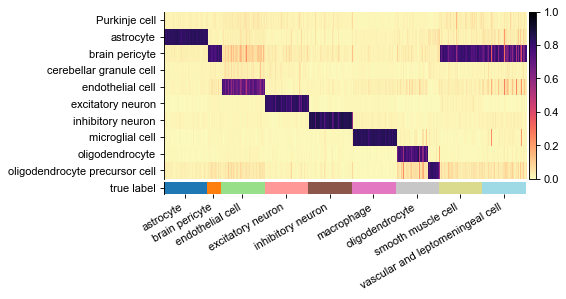

In [10]:
name_label = 'celltype'
cols_anno = ['celltype', 'predicted'][:]
df_probs = obs[list(classes)]


gs = pl.wrapper_heatmap_scores(
        df_probs.iloc[obs_ids2], obs.iloc[obs_ids2], ignore_index=True,
        col_label='celltype', col_pred='predicted',
        n_subsample=50,
        cmap_heat='magma_r',  # if prob_func == 'softmax' else 'RdBu_r'
        fp=figdir / f'heatmap_probas.pdf'
    )

gs.figure

## 2 Further analysis

By default, CAME will use the **last** layer of hidden states, as the embeddings, to produce cell- and gene-UMAP. 

> You can also load ALL of the model hidden states that have been seved during CAME's default pipeline:

```py
hidden_list = came.load_hidden_states(resdir / 'hidden_list.h5')
hidden_list  # a list of dicts
h_dict = hidden_list[-1]. # the last layer of hidden states
```

Make AnnData objects, storing only the CAME-embeddings and annotations, for cells and genes.

In [11]:
adt = pp.make_adata(h_dict['cell'], obs=dpair.obs, assparse=False, ignore_index=True)
gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)

# adt.write(resdir / 'adt_hidden_cell.h5ad')
# gadt.write_h5ad(resdir / 'adt_hidden_gene.h5ad')

adding columns to `adata.obs` (ignore_index=True):
original_name, dataset, REF, celltype, predicted, max_probs, is_right, astrocyte, inhibitory neuron, excitatory neuron, microglial cell, oligodendrocyte, cerebellar granule cell, oligodendrocyte precursor cell, endothelial cell, Purkinje cell, brain pericyte, done!
adding columns to `adata.obs` (ignore_index=True):
name, dataset, done!


### 2.1 UMAP of cell embeddings

... storing 'dataset' as categorical
... storing 'REF' as categorical
... storing 'celltype' as categorical
... storing 'predicted' as categorical


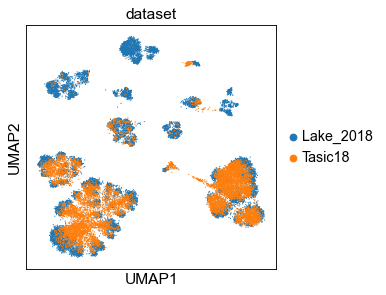

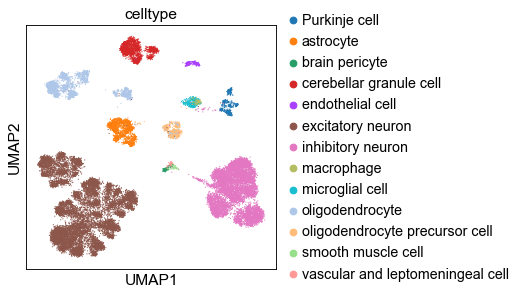

In [12]:
# from CAME_v0.utils.plot_pub import plot_pure_umap

sc.set_figure_params(dpi_save=200)

sc.pp.neighbors(adt, n_neighbors=15, metric='cosine', use_rep='X')
sc.tl.umap(adt)
# sc.pl.umap(adt, color=['dataset', 'celltype'], ncols=1)

ftype = ['.svg', ''][1]
sc.pl.umap(adt, color='dataset', save=f'-dataset{ftype}')
sc.pl.umap(adt, color='celltype', save=f'-ctype{ftype}')


In [13]:
# store UMAP coordinates
obs_umap = adt.obsm['X_umap']
obs['UMAP1'] = obs_umap[:, 0]
obs['UMAP2'] = obs_umap[:, 1]
obs.to_csv(resdir / 'obs.csv')
adt.write(resdir / 'adt_hidden_cell.h5ad')

In [14]:
# setting UMAP to the original adata
adata1.obsm['X_umap'] = obs_umap[obs_ids1]
adata2.obsm['X_umap'] = obs_umap[obs_ids2]

### 2.2 UMAP of genes

... storing 'name' as categorical
... storing 'dataset' as categorical


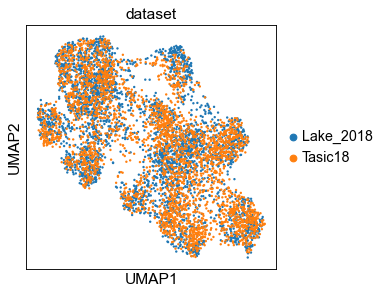

In [15]:
sc.pp.neighbors(gadt, n_neighbors=15, metric='cosine', use_rep='X')

# gadt = pp.make_adata(h_dict['gene'], obs=dpair.var.iloc[:, :2], assparse=False, ignore_index=True)
sc.tl.umap(gadt)
sc.pl.umap(gadt, color='dataset', )


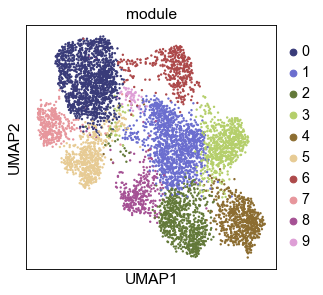

In [32]:
# joint gene module extraction 
sc.tl.leiden(gadt, resolution=.8, key_added='module')
sc.pl.umap(gadt, color='module', ncols=1, palette='tab20b')

# gadt.write(resdir / 'adt_hidden_gene.h5ad')

In [17]:
# link-weights between homologous gene pairs 
df_var_links = came.weight_linked_vars(
    gadt.X, dpair._vv_adj, names=dpair.get_vnode_names(),
    matric='cosine', index_names=dsnames,
)

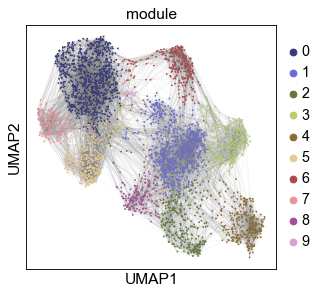

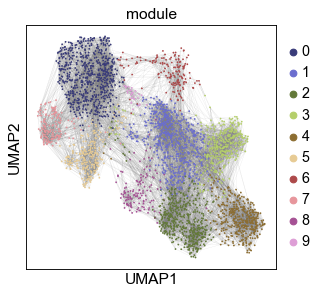

In [33]:
# gadt.obs_names = gadt.obs_names.astype(str)
gadt1, gadt2 = pp.bisplit_adata(gadt, 'dataset', dsnames[0], reset_index_by='name')

color_by = 'module'
palette = 'tab20b'
sc.pl.umap(gadt1, color=color_by, s=10, edges=True, edges_width=0.05,
           palette=palette,
           save=f'_{color_by}-{dsnames[0]}')
sc.pl.umap(gadt2, color=color_by, s=10, edges=True, edges_width=0.05,
           palette=palette,
           save=f'_{color_by}-{dsnames[0]}')

### 2.3 Gene-expression-profiles (for each cell type) on gene UMAP

Compute average expressions for each cell type.

In [26]:
# averaged expressions
avg_expr1 = pp.group_mean_adata(
    adatas[0], groupby=key_class1,
    features=dpair.vnode_names1, use_raw=True)
avg_expr2 = pp.group_mean_adata(
    adatas[1], groupby=key_class2,
    features=dpair.vnode_names2, use_raw=True)

# z-scores across cell types
avg_expr_add1, avg_expr_add2 = list(map(
    lambda x: pp.zscore(x.T).T, (avg_expr1, avg_expr2)
))

# add annos
pp.add_obs_annos(gadt1, avg_expr_add1, ignore_index=True)
pp.add_obs_annos(gadt2, avg_expr_add2, ignore_index=True)

gadt1.write(resdir / 'adt_hidden_gene1.h5ad')  # scanpy raise errors
gadt2.write(resdir / 'adt_hidden_gene2.h5ad')



Computing averages grouped by cell_ontology_class
Calculating feature averages for 10 groups
['Purkinje cell' 'astrocyte' 'brain pericyte' 'cerebellar granule cell'
 'endothelial cell' 'excitatory neuron' 'inhibitory neuron'
 'microglial cell' 'oligodendrocyte' 'oligodendrocyte precursor cell']
Computing averages grouped by cell_ontology_class
Calculating feature averages for 9 groups
['astrocyte' 'brain pericyte' 'endothelial cell' 'excitatory neuron'
 'inhibitory neuron' 'macrophage' 'oligodendrocyte' 'smooth muscle cell'
 'vascular and leptomeningeal cell']
adding columns to `adata.obs` (ignore_index=True):
NOTE that column "Purkinje cell" will be covered by new values
Purkinje cell, NOTE that column "astrocyte" will be covered by new values
astrocyte, NOTE that column "brain pericyte" will be covered by new values
brain pericyte, NOTE that column "cerebellar granule cell" will be covered by new values
cerebellar granule cell, NOTE that column "endothelial cell" will be covered by n

plot cell type gene-profiles (plot all the cell types) on UMAP

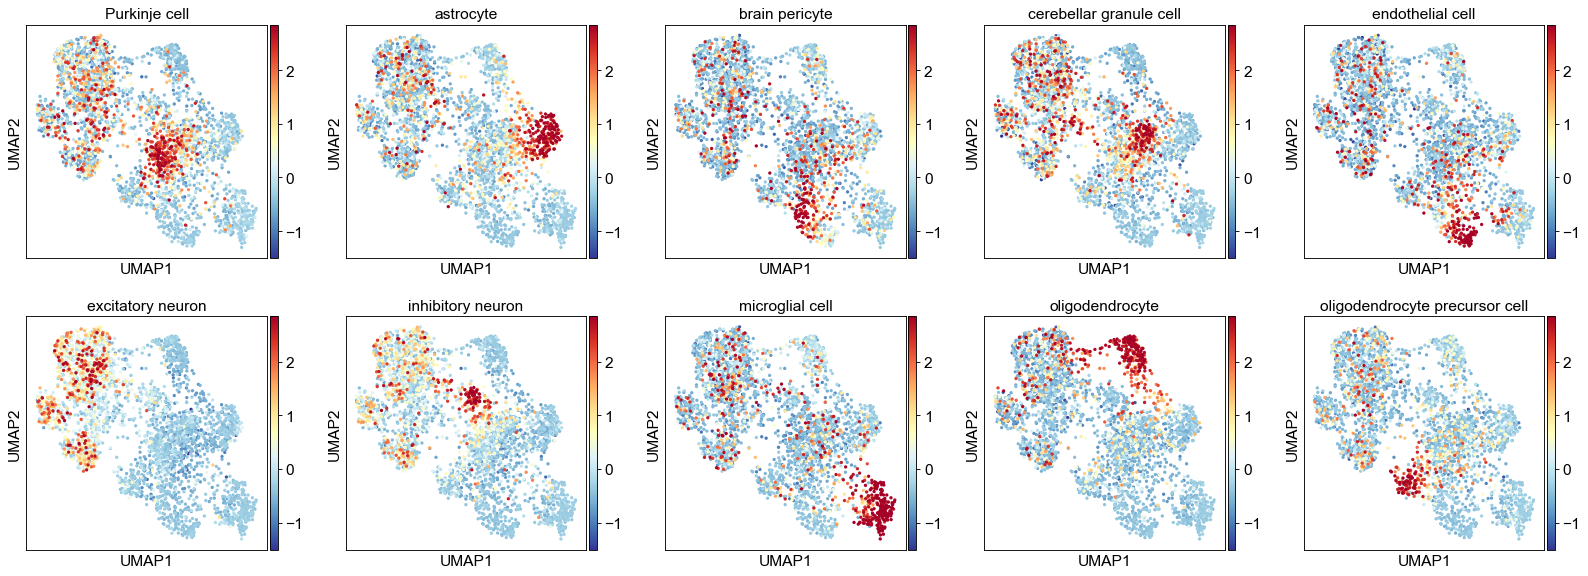

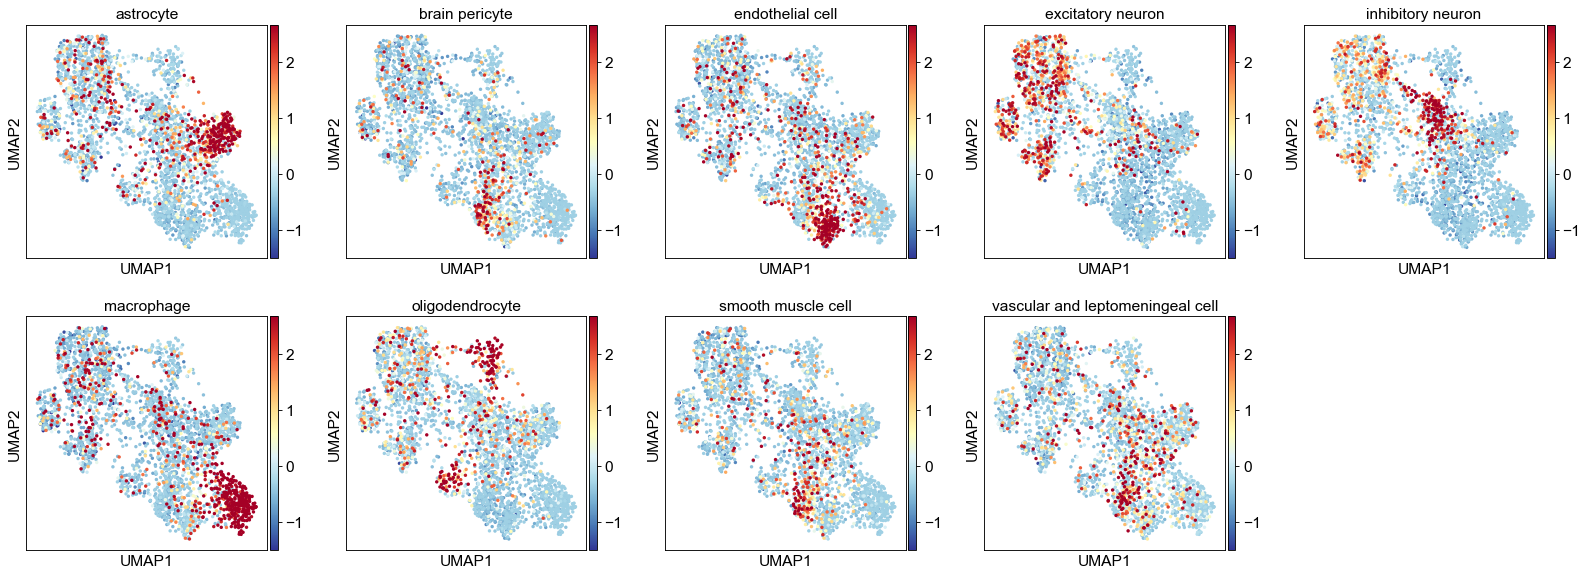

In [21]:
sc.set_figure_params(fontsize=14)

ctypes1 = avg_expr1.columns.tolist()
ctypes2 = avg_expr2.columns.tolist()
cmap_expr = 'RdYlBu_r'
vmax = None
vmin = - 1.5
plkwds = dict(color_map=cmap_expr, vmax=vmax, vmin=vmin, ncols=5, )

sc.pl.umap(gadt1, color=ctypes1,
           # edges=True, size=50,
           save=f'_exprAvgs-{dsn1}-all.png', **plkwds)
sc.pl.umap(gadt2, color=ctypes2,
           # edges=True, size=50,
           save=f'_exprAvgs-{dsn2}-all.png', **plkwds)


Text(0.5, 1.0, 'Purkinje cell')

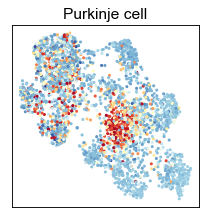

In [22]:
_ctype = ctypes1[0]
_xy = gadt1.obsm['X_umap'].T
_color_values = gadt1.obs[_ctype]

fig, ax = plt.subplots(1, 1, figsize=(3, 3), gridspec_kw={'wspace': 0.1})
ax.scatter(*_xy, s=3,
           c=_color_values, 
           cmap=cmap_expr, 
           vmin=-1.5, vmax=None
          )
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title(_ctype)
# ax.set_frame_on(False)

### 2.4 Abstracted graph

In [23]:
norm_ov = ['max', 'zs', None][1]
cut_ov = 0.  # 5#(0.5, 2.5)
# norm_ov = 'zs'
# cut_ov = (0.5, 2.5)
ovby = ['expr', 'attn'][0]
groupby_var = 'module'
obs_labels1, obs_labels2 = adt.obs['celltype'][dpair.obs_ids1], \
                           adt.obs['celltype'][dpair.obs_ids2]
var_labels1, var_labels2 = gadt1.obs[groupby_var], gadt2.obs[groupby_var]

sp1, sp2 = 'human', 'mouse'
g = came.make_abstracted_graph(
    obs_labels1, obs_labels2,
    var_labels1, var_labels2,
    avg_expr1, avg_expr2,
    df_var_links,
    tags_obs=(f'{sp1} ', f'{sp2} '),
    tags_var=(f'{sp1} module ', f'{sp2} module '),
    cut_ov=cut_ov,
    norm_mtd_ov=norm_ov,
)


3352 3173
---> ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
Edges with weights lower than 0 were cut out.
Edges with weights lower than 0 were cut out.
---> avg_vo1
                  Purkinje cell  astrocyte  brain pericyte  \
__temp_labels__                                             
0                     0.115088  -0.090871       -0.214293   
1                     0.809269  -0.087569       -0.156383   
2                    -0.215733  -0.219896        1.094208   
3                    -0.247792   1.988619       -0.029682   
4                    -0.235564  -0.312963       -0.192215   
5                     0.149117  -0.184407       -0.131044   
6                    -0.336328  -0.155802       -0.183836   
7                     0.088722  -0.156662       -0.191488   
8                    -0.041448  -0.082519       -0.157142   
9                    -0.084649  -0.386319       -0.283940   

                 cerebellar granule cell  endothelial cell  excitatory neuron  \
__temp_labels_

[10, 10, 10, 9]
figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\abstracted_graph-module-cut0.0-zs-expr.pdf


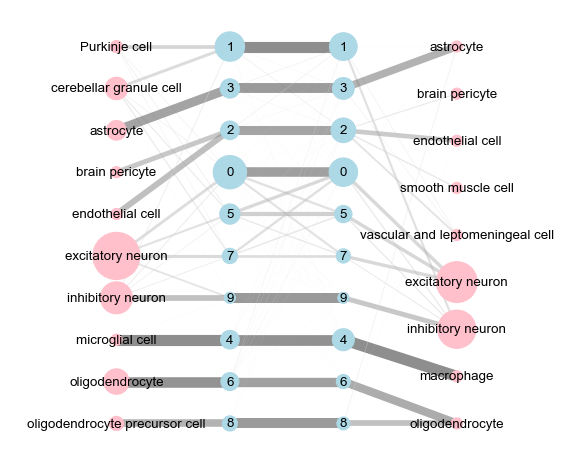

In [24]:
''' visualization '''
fp_abs = figdir / f'abstracted_graph-{groupby_var}-cut{cut_ov}-{norm_ov}-{ovby}.pdf'
ax = pl.plot_multipartite_graph(
    g, edge_scale=10,
    figsize=(9, 7.5), alpha=0.5, fp=fp_abs)  # nodelist=nodelist,

ax.figure

[10, 10, 10, 9]
figure has been saved into:
	..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\figs\abstracted_graph-nolabels.pdf


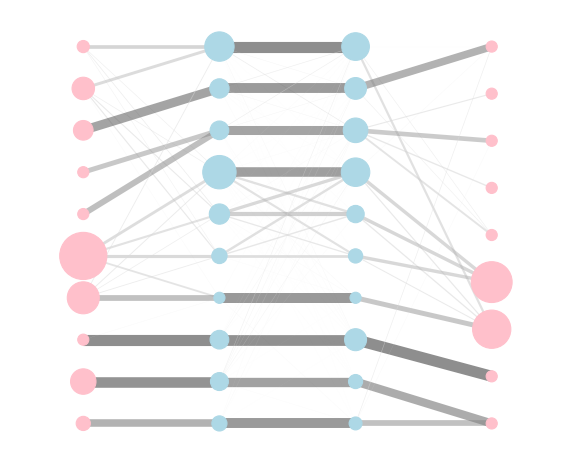

In [25]:
# unlabeled
ax = pl.plot_multipartite_graph(
    g, edge_scale=10, figsize=(9, 7.5), alpha=0.5,
    xscale=1.25,
    fp=figdir / f'abstracted_graph-nolabels.pdf',
    with_labels=False)  # nodelist=nodelist,

ax.figure

In [35]:
came.save_pickle(g, resdir / 'abs_graph.pickle')

object saved into:
	 ..\_case_res\('Lake_2018', 'Tasic18')-(09-04 13.02.42)\abs_graph.pickle


In [34]:
from came import pl

cmap_pt = 'tab20'# 'tab20b'
angle_x, angle_y = 10, 85

#cmap_pt = 'tab20b'
#angle_x, angle_y = 0, 100

ax = pl.embedding_mock3d(gadt1, 'module', cmap_pt=cmap_pt, edges=True, linewidth=0.05,
                      angle_x=angle_x, angle_y=angle_y, )
pl._save_with_adjust(ax.figure, fdir / f'umap-plane-{dsn1}.pdf', dpi=400)
pl._save_with_adjust(ax.figure, fdir / f'umap-plane-{dsn1}.svg', dpi=400, transparent=True)

ax = pl.embedding_mock3d(gadt2, 'module', cmap_pt=cmap_pt, edges=True, linewidth=0.05,
                      angle_x=angle_x, angle_y=angle_y, )
pl._save_with_adjust(ax.figure, fdir / f'umap-plane-{dsn2}.pdf', dpi=400)
pl._save_with_adjust(ax.figure, fdir / f'umap-plane-{dsn2}.svg', dpi=400, transparent=True)

ax.figure


AttributeError: module 'came.utils.plot' has no attribute 'embedding_mock3d'